# Simple VEN for Capacity Management
- VEN process:
  - creates a subscription amount
  - creates a reservation amount
  - Send reservation to VTN 
  - Adjust subcription amount according to VTN prices 
  - Restart process

In [39]:
import random
import matplotlib.pyplot as plt
import requests

class VEN:
    def __init__(self, normal_capacity=5, intervals=96):
        """
        Initialize the VEN with:
        - normal_capacity: Maximum capacity the VEN is subscribed to.
        - intervals: Number of 15-minute intervals in a day (default 96).
        """
        self.normal_capacity = normal_capacity
        self.intervals = intervals
        self.base_load_shape = []  # Stores the base load shape for the day
        self.reservation_load_shape = []  # Stores the load shape with reservations

    def generate_random_load_shape(self):
        """
        Generate a random load shape where each interval load is between 0 and 4 kW.
        """
        self.base_load_shape = [random.uniform(0, 4) for _ in range(self.intervals)]
        print("VEN: Generated random load shape for the day.")

    def calculate_reservation_load_shape(self):
        """
        Calculate the load shape including reservations above the normal subscription level.
        """
        self.reservation_load_shape = self.base_load_shape.copy()

    def request_additional_capacity(self, start_interval, end_interval, capacity):
        """
        Request additional capacity for a given range of intervals.
        
        Args:
        - start_interval (int): Start interval (1-indexed).
        - end_interval (int): End interval (1-indexed).
        - capacity (float or list): Additional capacity requested. 
          If a single value, it is applied to all intervals. If a list, it must match the range length.
        """
        # Ensure reservation_load_shape is initialized
        if not self.reservation_load_shape:
            self.calculate_reservation_load_shape()
        
        # Calculate the number of intervals in the range
        num_intervals = end_interval - start_interval + 1

        # Handle single capacity value for all intervals
        if isinstance(capacity, (int, float)):
            capacity_list = [capacity] * num_intervals
        # Handle list of varying capacity levels
        elif isinstance(capacity, list):
            if len(capacity) != num_intervals:
                raise ValueError(f"Capacity list length ({len(capacity)}) does not match the interval range ({num_intervals}).")
            capacity_list = capacity
        else:
            raise ValueError("Capacity must be either a single value or a list.")

        # Apply the additional capacity to the reservation load shape
        for i in range(start_interval - 1, end_interval):
            self.reservation_load_shape[i] += capacity_list[i - (start_interval - 1)]

        print(f"VEN: Requested additional capacity from interval {start_interval} to {end_interval}.")

    def plot_load_shapes(self):
        """
        Plot the base load shape and the load shape with reservations.
        """
        intervals = range(1, self.intervals + 1)
        plt.figure(figsize=(12, 6))
        plt.plot(intervals, self.base_load_shape, label="Base Load Shape", color="blue", linewidth=2)
        plt.plot(intervals, self.reservation_load_shape, label="Load Shape with Reservations", color="orange", linestyle="--", linewidth=2)
        plt.axhline(y=self.normal_capacity, color="red", linestyle=":", label="Reservation Limit")
        plt.title("VEN Load Shape and Reservations", fontsize=14)
        plt.xlabel("Interval (15 minutes each)", fontsize=12)
        plt.ylabel("Load (kW)", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


VEN: Generated random load shape for the day.
VEN: Requested additional capacity from interval 20 to 25.
VEN: Requested additional capacity from interval 40 to 44.


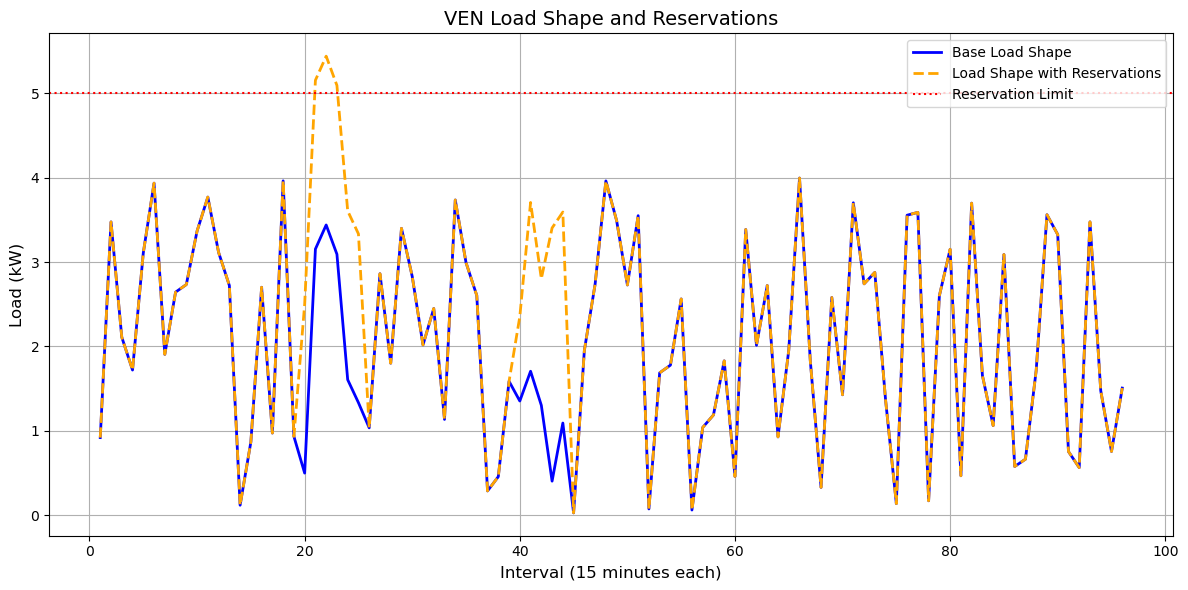

In [40]:
# Simulation
ven = VEN()

# Generate a random load shape for the day
ven.generate_random_load_shape()

# Calculate the load shape including reservations
ven.calculate_reservation_load_shape()

# Request additional capacity
# Example 1: Single capacity level for the range
ven.request_additional_capacity(start_interval=20, end_interval=25, capacity=2)

# Example 2: Varying capacities for the range
ven.request_additional_capacity(start_interval=40, end_interval=44, capacity=[1, 2, 1.5, 3, 2.5])

# Plot the load shapes
ven.plot_load_shapes()

In [81]:
import requests
import json
from datetime import datetime, timedelta
# assuming 1 hour duration intervals
# not sure based on examples what the format of times should be
# may need to convert the time so that its format is always 2 digits, like 01 rather than 1
# kWh is used in the capacity request example, but doesn't make sense to me so using kW instead
HEADERS = {
            "Content-Type": "application/json",
            "Authorization": "Bearer ven_token"
        }

class CapacityAPIInterface:
    def __init__(self, api_url, client_name):
        """
        Initialize the API interface with the base API URL.
        
        Args:
        - api_url (str): The URL of the REST API endpoint to communicate with.
        """
        self.api_url = api_url
        self.client_name = client_name
    
    def get_capacity_event(self):
        r = requests.get("http://localhost:8080/openadr3/3.0.1/events", headers = HEADERS)
        # Should log the ID 
        return r

    def post_capacity_request(self, program_id, event_id, intervals):
        """
        Post a capacity request event to the REST API.
        
        Args:
        - program_id (str): The ID of the program.
        - event_id (str): The event ID.
        - intervals (list): List of intervals (start, duration). capacity_request_values (list): List of capacity values for each interval.
        
        Returns:
        - Response object from the POST request.
        """
        
        intervals_payload = []
        for i, interval in enumerate(intervals):
            interval_payload = {
                "id": i,
                "payloads": [{
                    "type": "IMPORT_CAPACITY_RESERVATION",
                    "values": [interval[1]]
                }]
            }
            intervals_payload.append(interval_payload)

        payload = {
            "reportName": "capacityReservationReport",
            "programID": program_id,
            "eventID": event_id,
            "clientName": self.client_name,
            "payloadDescriptors": [{
                "payloadType": "IMPORT_CAPACITY_RESERVATION",
                "units": "KW" # KWH originally
                }],
            "resources": [{
            "resourceName": "Resource_1",
            "intervalPeriod": {
                "start": f"2024-11-13T{intervals[0][0]}:00:00.000Z",
                "duration": "PT1H"
            },
            "intervals": intervals_payload
            }]
        }
        headers = HEADERS
        print(json.dumps(payload, indent = 4))
        try:
            response = requests.post(f"{self.api_url}/capacity_request", json=payload, headers=headers)
            
            if response.status_code == 200:
                print(f"Capacity request for program {program_id} successful.")
            else:
                print(f"Error: {response.status_code} - {response.text}")
            return response
        except requests.exceptions.RequestException as e:
            print(f"Error while posting capacity request: {e}")
            return None

In [88]:
# Example usage:
api_url = "http://localhost:8080/openadr3/3.0.1/"  # Replace with your API URL
ven_api = CapacityAPIInterface(api_url,'myClient')
r = ven_api.get_capacity_event()
print('status code: ',r.status_code, '| text: ',r.text)

status code:  200 | text:  []



In [84]:

# Capacity Subscription example
program_id = "44"
event_id = "1"
resource_name = "Resource_1"
# (interval number, capacity value)
# making a call for 5 kW at a and 9 am 
intervals = [(8,5),(9,4)]
ven_api.post_capacity_request(program_id, event_id, intervals)

{
    "reportName": "capacityReservationReport",
    "programID": "44",
    "eventID": "1",
    "clientName": "myClient",
    "payloadDescriptors": [
        {
            "payloadType": "IMPORT_CAPACITY_RESERVATION",
            "units": "KW"
        }
    ],
    "resources": [
        {
            "resourceName": "Resource_1",
            "intervalPeriod": {
                "start": "2024-11-13T8:00:00.000Z",
                "duration": "PT1H"
            },
            "intervals": [
                {
                    "id": 0,
                    "payloads": [
                        {
                            "type": "IMPORT_CAPACITY_RESERVATION",
                            "values": [
                                5
                            ]
                        }
                    ]
                },
                {
                    "id": 1,
                    "payloads": [
                        {
                            "type": "IMPORT_CAPACITY_RE

<Response [404]>

In [ ]:
scrap 
    def post_capacity_subscription(self, program_id, event_id, resource_name, intervals, capacity_values):
        """
        Post a capacity subscription event to the REST API.
        
        Args:
        - program_id (str): The ID of the program.
        - event_id (str): The event ID.
        - self.client_name (str): The client name.
        - resource_name (str): The resource name.
        - intervals (list): List of intervals (start, duration).
        - capacity_values (list): List of capacity values for each interval.
        
        Returns:
        - Response object from the POST request.
        """
        # Generate payload based on the capacity subscription format
        intervals_payload = []
        # Below if intervals need to be hourly
        for i, interval in enumerate(intervals):
            interval_payload = {
                "id": i,
                "payloads": [{
                    "type": "CAPACITY_RESERVATION",
                    "values": [interval[1]]
                }]
            }
            intervals_payload.append(interval_payload)

        payload = {
            "reportName": "capacitySubscriptionReport",
            "programID": program_id,
            "eventID": event_id,
            "clientName": self.client_name,
            "payloadDescriptors": [{
                "payloadType": "CAPACITY_RESERVATION",
                "units": "KWH"
            }],
            "resources": [{
                "resourceName": resource_name,
                "intervalPeriod": {
                    "start": f"2024-11-13T{intervals[0]}:00:00.000Z",  # Start of the first interval
                    "duration": "PT1H"  # Assuming 1 hour duration for each interval
                },
                "intervals": intervals_payload
            }]
        }
        
        headers = {
            "Content-Type": "application/json",
            "Authorization": "Bearer ven_token"
        }
        
        try:
            response = requests.post(f"{self.api_url}/capacity_subscription", json=payload, headers=headers)
            
            if response.status_code == 200:
                print(f"Capacity subscription for program {program_id} successful.")
            else:
                print(f"Error: {response.status_code} - {response.text}")
            return response
        except requests.exceptions.RequestException as e:
            print(f"Error while posting capacity subscription: {e}")
            return None